In [1]:
#John Crossman jcc395, Steven Jiang ssj54

In [2]:
#Imports
import qiskit
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.extensions import Initialize

In [3]:
#Class for quantum convolutional filter
class Quanvoluter:
    def __init__(self, kernel_size=2, stride=1):
        self.kernel_size = kernel_size
        self.stride = stride
        self.thetas = np.zeros((kernel_size, kernel_size))
        
    #This function converts grayscale values to r_y rotation values 
    def quantum_data_encoder(self, img):
        img = np.array(img)
        init_thetas = img * np.pi / 2
        return init_thetas
    
    #img_sec is 2 by 2 section of image
    #This function creates out quantum circuit
    def circuit_builder(self, img_sec, thetas = None):
        if (thetas is None):
            thetas = self.thetas
        kernel_size = self.kernel_size
        thetas = thetas.flatten()
        
        img_sec = img_sec.flatten()
        qr = QuantumRegister(kernel_size * kernel_size, name="q")
        cr = ClassicalRegister(kernel_size * kernel_size, name="c")
        qc = QuantumCircuit(qr, cr)
        qubit_i = 0
        for img in img_sec:
            qc.ry(img, qubit_i)
            qubit_i += 1
        qubit_i = 0
        qc.barrier()
        for theta in thetas:
            qc.ry(theta, qubit_i)
            qubit_i += 1
        
        #CNOTS
        
        qubit_i = 0
        while(qubit_i < ((kernel_size * kernel_size) - 1)):
            qc.cx(qubit_i, qubit_i + 1)
            qubit_i += 2
            
        qubit_i = 1
        while(qubit_i < ((kernel_size * kernel_size) - 1)):
            qc.cx(qubit_i, qubit_i + 1)
            qubit_i += 2
        
        #MEASUREMENTS
        
        qc.barrier()
        
        qubit_i = 0
        while(qubit_i < ((kernel_size * kernel_size))):
            qc.measure(qubit_i, qubit_i)
            qubit_i += 1
        
        return qc
    
    #computes expectation of Z
    def corr_measure(self, circ):
        shots = 8192
        backend = qiskit.Aer.get_backend('qasm_simulator') #change this for real quantum computer
        qobj = assemble(circ, shots=shots)
        result = backend.run(qobj).result()
        counts = result.get_counts(circ)
        sum = 0
        for key in counts:
            key_arr = list(key)
            key_arr = np.array(key_arr)
            key_arr_ints = np.array([int(x) for x in key_arr])
            key_sum = np.sum(key_arr_ints)
            weighted_val = ((-1)**key_sum) * counts[key]
            sum = sum + weighted_val
        return sum / shots
        
    def feature_mapper(self, img): #img is set of init thetas for the image data
        kernel_size = self.kernel_size
        stride = self.stride

        rows, cols = np.shape(img)
        feature_map_rows = int(((rows - kernel_size) / stride) + 1)
        feature_map_cols = int(((cols - kernel_size) / stride) + 1)
        feature_map = np.zeros((feature_map_rows, feature_map_cols)) 
        i = 0
        row_offset = 0
        col_offset = 0
        
        while(i < feature_map_rows * feature_map_cols):
            img_sec = img[row_offset:(row_offset+kernel_size), col_offset:(col_offset+kernel_size)]
            circ = self.circuit_builder(img_sec)
            x = self.corr_measure(circ)
            feature_map[(i // feature_map_cols), (i % feature_map_cols)] = x
            i += 1
            col_offset += stride
            if (col_offset + kernel_size > cols):
                row_offset += stride
                col_offset = 0
        return feature_map
    
    #Helper function for quantum grad calcs
    def sub_grad_calc(self, img_sec):
        shift = np.pi / 2
        thetas = self.thetas
        thetas_copy = thetas.copy()
        grads = np.zeros(len(thetas), dtype=float)
        print(thetas)
        
        for i in range(len(thetas)):
            thetas_copy[i] += shift
            print(thetas_copy)
            pos_circ = self.circuit_builder(img_sec, thetas = thetas_copy)
            thetas_copy = thetas.copy()
            thetas_copy[i] -= shift
            print(thetas_copy)
            neg_circ = self.circuit_builder(img_sec, thetas = thetas_copy)
            thetas_copy = thetas.copy()
            grads[i] = 0.5 * (self.corr_measure(pos_circ) - self.corr_measure(neg_circ))
        
        return grads
    
    def grad_calc(self, img):
        shift = np.pi / 2
        thetas = self.thetas
        thetas_copy = thetas
        grads = np.zeros(len(thetas), dtype=float)
        
        #loop over all 2 by 2 windows, and add up all gradient calcs.
        
        kernel_size = self.kernel_size
        stride = self.stride

        rows, cols = np.shape(img)
        feature_map_rows = int(((rows - kernel_size) / stride) + 1)
        feature_map_cols = int(((cols - kernel_size) / stride) + 1)
        feature_map = np.zeros((feature_map_rows, feature_map_cols)) 
        i = 0
        row_offset = 0
        col_offset = 0
        
        while(i < feature_map_rows * feature_map_cols):
            img_sec = img[row_offset:(row_offset+kernel_size), col_offset:(col_offset+kernel_size)]
            grads += self.sub_grad_calc(img_sec)
            i += 1
            col_offset += stride
            if (col_offset + kernel_size > cols):
                row_offset += stride
                col_offset = 0
        
        return grads
        
    def thetas_updates(self, img):
        grads = self.grad_calc(img)
        self.thetas = self.thetas - grads

In [4]:
#First, test circuit building

In [5]:
img_sec_test = np.array([[0.5, 1], [0, 1]]) #Greyscale values

In [6]:
img_sec_test

array([[0.5, 1. ],
       [0. , 1. ]])

In [7]:
q_test = Quanvoluter()

In [8]:
theta_vals_test = q_test.quantum_data_encoder(img_sec_test)

In [9]:
theta_vals_test

array([[0.78539816, 1.57079633],
       [0.        , 1.57079633]])

In [10]:
#quantum data encoder works!

In [11]:
test_circ = q_test.circuit_builder(theta_vals_test)

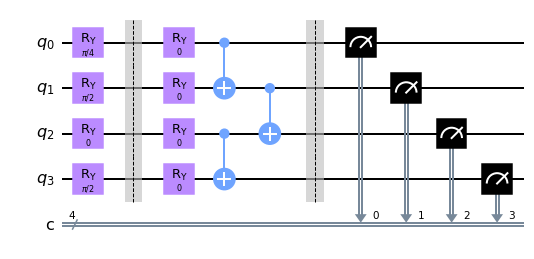

In [12]:
test_circ.draw(output = 'mpl')

In [13]:
#Looks like the circuit is building properly!
#Let's test generalization to arbitrary kernel size.

In [14]:
q_test_big = Quanvoluter(kernel_size = 4)

In [15]:
img_vals_test_big = [[1, 1, 0, 0.5], [1, 1, 0, 0.5], [0.5, 1, 0, 1],  [1, 1, 1, 1]]

In [16]:
theta_vals_test_big = q_test_big.quantum_data_encoder(img_vals_test_big)

In [17]:
theta_vals_test_big

array([[1.57079633, 1.57079633, 0.        , 0.78539816],
       [1.57079633, 1.57079633, 0.        , 0.78539816],
       [0.78539816, 1.57079633, 0.        , 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633]])

In [18]:
test_circ_big = q_test_big.circuit_builder(theta_vals_test_big)

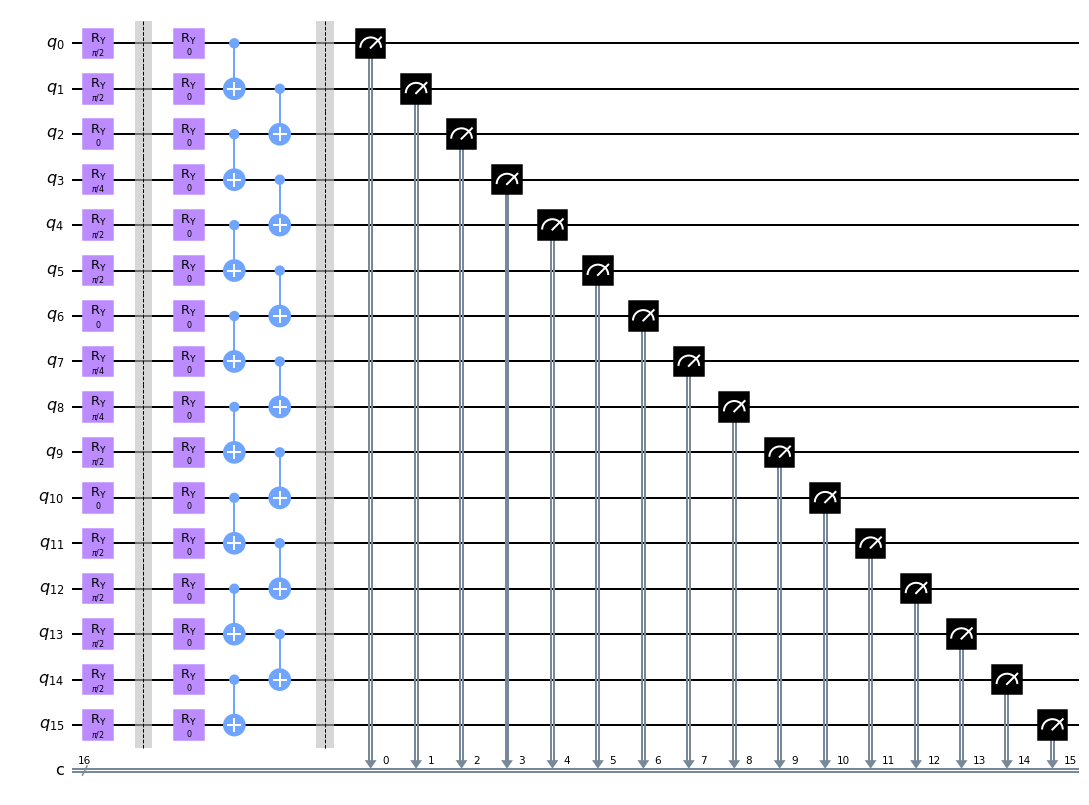

In [19]:
test_circ_big.draw(output='mpl')

In [20]:
#It works!

In [21]:
#Test circuit builder for a "learned" theta vector for second set of R_y gates

In [22]:
q_test.thetas = np.array([np.pi, np.pi / 2, 0, 3* np.pi/2])

In [23]:
test_circ = q_test.circuit_builder(theta_vals_test)

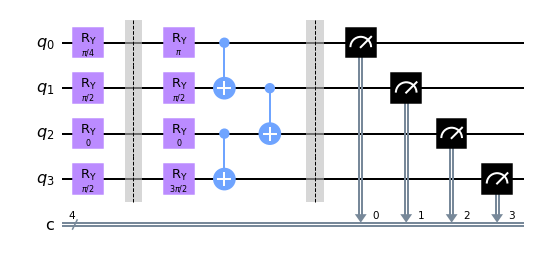

In [24]:
test_circ.draw(output='mpl')

In [25]:
#It works!

In [26]:
#Test correlational measurement

In [27]:
qr = QuantumRegister(4, name="q")
cr = ClassicalRegister(4, name="c")
special_circ = QuantumCircuit(qr, cr)

In [28]:
special_circ.x(0)

In [29]:
special_circ.barrier()

In [30]:
special_circ.measure(0, 0)
special_circ.measure(1, 1)
special_circ.measure(2, 2)
special_circ.measure(3, 3)

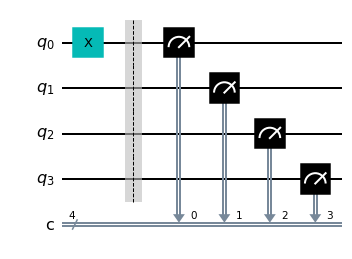

In [31]:
special_circ.draw(output='mpl')

In [32]:
q_test.corr_measure(special_circ)

-1.0

In [33]:
#negative one as expected. Next test should be positive one.

In [34]:
qr = QuantumRegister(4, name="q")
cr = ClassicalRegister(4, name="c")
special_circ = QuantumCircuit(qr, cr)

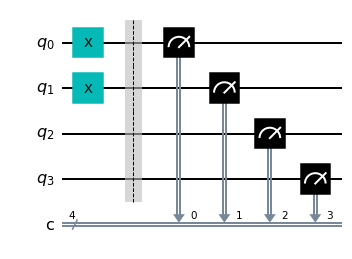

In [35]:
special_circ.x(0)
special_circ.x(1)
special_circ.barrier()
special_circ.measure(0, 0)
special_circ.measure(1, 1)
special_circ.measure(2, 2)
special_circ.measure(3, 3)
special_circ.draw(output='mpl')

In [36]:
q_test.corr_measure(special_circ)

1.0

In [37]:
#corr_measure works!

In [38]:
#test subgradient

In [39]:
q_test.thetas = np.array([0.0, 0.0, 0.0, 0.0])

In [40]:
q_test.thetas

array([0., 0., 0., 0.])

In [41]:
q_test.sub_grad_calc(np.array([0.0,0.0,0.0,0.0]))

[0. 0. 0. 0.]
[1.57079633 0.         0.         0.        ]
[-1.57079633  0.          0.          0.        ]
[0.         1.57079633 0.         0.        ]
[ 0.         -1.57079633  0.          0.        ]
[0.         0.         1.57079633 0.        ]
[ 0.          0.         -1.57079633  0.        ]
[0.         0.         0.         1.57079633]
[ 0.          0.          0.         -1.57079633]


array([0.0065918 , 0.        , 0.        , 0.00256348])

In [42]:
#sub_grad works!

In [43]:
test_img = np.array([[0.0,0.0],[0.0,0.0]])

In [44]:
q_test.thetas_updates(test_img)

[0. 0. 0. 0.]
[1.57079633 0.         0.         0.        ]
[-1.57079633  0.          0.          0.        ]
[0.         1.57079633 0.         0.        ]
[ 0.         -1.57079633  0.          0.        ]
[0.         0.         1.57079633 0.        ]
[ 0.          0.         -1.57079633  0.        ]
[0.         0.         0.         1.57079633]
[ 0.          0.          0.         -1.57079633]


In [45]:
q_test.thetas

array([0.00402832, 0.        , 0.        , 0.00109863])

In [46]:
#This works!

In [47]:
#finally, test feature mapper

In [48]:
test_img = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]])

In [49]:
test_img

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]])

In [50]:
test_img = q_test.quantum_data_encoder(test_img)

In [51]:
test_img

array([[1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633],
       [1.57079633, 1.57079633, 1.57079633, 1.57079633, 1.57079633]])

In [52]:
q_test.thetas = np.array([-np.pi/2, -np.pi/2, -np.pi/2, -np.pi/2])

In [53]:
#should map everything to one.

In [54]:
q_test.feature_mapper(test_img)

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [55]:
q_test.thetas = np.array([0.0, 0.0, 0.0, 0.0])

In [56]:
q_test.feature_mapper(test_img)

array([[ 0.00024414, -0.01855469, -0.01342773, -0.02514648],
       [ 0.00537109, -0.00195312,  0.00708008, -0.00805664],
       [ 0.00512695,  0.00024414, -0.00878906,  0.00488281],
       [-0.01733398, -0.02172852, -0.00512695, -0.00512695]])

In [146]:
#The quantum convolutional filter appears to be working.

In [57]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

In [58]:
import torch
import torchvision

In [59]:
import tensorflow as tf

In [60]:
#Hybrid network class for a single convolutional layer.
class Hybrid(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Quanvoluter()
        self.fc1 = nn.Linear(169, 25)
        self.fc2 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(torch.from_numpy(np.array([self.conv1.feature_mapper(x)])), 2))
        x = x.view(-1, 169)
        x = F.relu(self.fc1(x.float()))
        x = self.fc2(x)
        return F.log_softmax(x)

In [61]:
#Note: the rest of the blow code is for the classical network and is largely taken from 
#"https://nextjournal.com/gkoehler/pytorch-mnist."
#We were going to use the classical network solely to test it against the hybrid CNN. 
#However, we have modified the network module to include the right number of convolutional layers and fully connected 
#layers/neurons we planned on using. However, the rest of the code is largely the same as that found at
#"https://nextjournal.com/gkoehler/pytorch-mnist."
#Credit: Gregor Koehler Feb 17, 2020

In [62]:
#Modified class for CCNN

In [63]:
class CNet(nn.Module):
    def __init__(self):
        super(CNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, kernel_size=2)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=2)
        self.fc1 = nn.Linear(36, 25)
        self.fc2 = nn.Linear(25, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 36)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

In [64]:
net = CNet() #net = Hybrid()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [65]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [66]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,)) #mean, std normalization
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [67]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [68]:
def train(epoch):
    net.train
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        #net.conv1.thetas_updates(data) #back-propagation for the QCNN
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))

In [69]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = net(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [70]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\johnn\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
C:\Users\johnn\.julia\conda\3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3059, Accuracy: 1044/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.317006
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.276374
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.284849
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.299467
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.281609
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.276863
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.286090
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.300937
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.290903
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.308707
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.300022
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.301605
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.281618
Train Epoch: 1 [8320/60000 (14%)]	Loss: 2.284157
Train Epoch: 1 [8960/60000 (15%)]	Loss: 2.272540
Train Epoch: 1 [9600/60000 (16%)]	Loss: 2.283509
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.271096
Train Epoch: 1 [10880/60000 (18%)]	Loss: 2.267133
Train Epoch: 1 [11520/60000 (19%)]	Loss: 2.290675
Train Epoch: 1 [12160

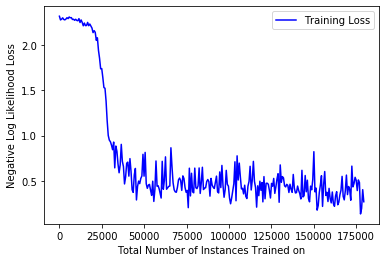

In [71]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
#plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Training Loss', 'Test Loss'], loc='upper right')
plt.xlabel('Total Number of Instances Trained on')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()